### Data Challenge 1
#### Plan of Attack:
##### Visualize Data
##### split data into training/test
##### run logistic regression with ridge regularization
##### look at model fit
##### play with model as needed
##### test model

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import  numpy as np
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn import model_selection, linear_model, preprocessing, metrics, ensemble
%matplotlib inline

In [2]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data',
                    names = ['id', 'thickness', 'u_size', 'u_shape', 'adhesion', 'size', 'bare', 'chromatin', 'nucleoli', 'mitoses', 'class']
                  )

In [3]:
data.shape
data.columns

Index(['id', 'thickness', 'u_size', 'u_shape', 'adhesion', 'size', 'bare',
       'chromatin', 'nucleoli', 'mitoses', 'class'],
      dtype='object')

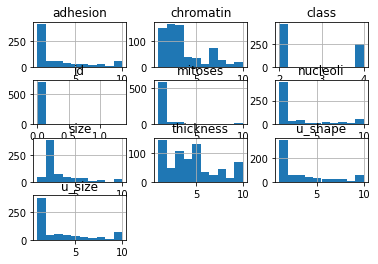

In [4]:
data.hist()
plt.show()

#### Data is slightly imbalanced- more benign than malignant

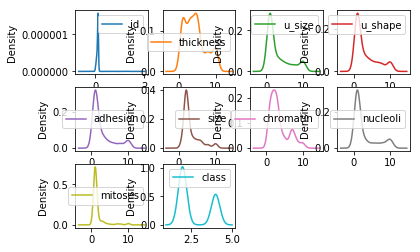

In [5]:
data.plot(kind='density', subplots=True, layout = (3, 4), sharex=False)
plt.show()

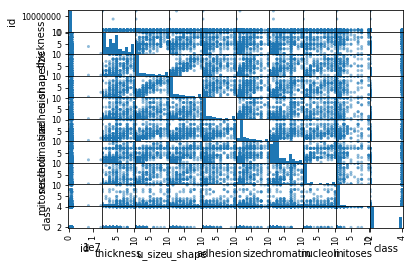

In [6]:
scatter_matrix(data)
plt.show()

#### uniformity of size and shape are correlated

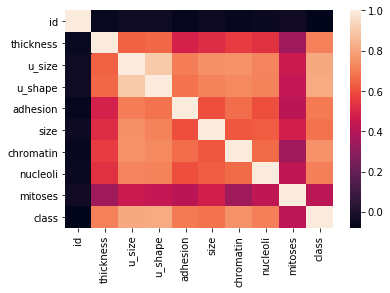

In [7]:
sns.heatmap(data.corr())
plt.show()

In [8]:
#clean data
#remove '?'
data.replace({'?': None}, inplace=True)

In [9]:
#remove ID column
data_sub = data.dropna(axis=0)
response = data_sub['class']
data_sub.astype(float, inplace = True)
response.replace({2: 0, 4: 1}, inplace = True)
data_sub = data_sub.drop(['id', 'class','u_shape'], axis=1)#remove u_shape because of correlation with u_size
data_sub.columns
print(data_sub.shape)
response.shape

(683, 8)


/home/pamela/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


(683,)

In [10]:
#check all data is within range it should be
#is all response 2 or 4
np.unique(response)


array([0, 1])

In [11]:
for var in data_sub.columns:
    print(np.unique(data_sub[var]))

[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]
['1' '10' '2' '3' '4' '5' '6' '7' '8' '9']
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8 10]


In [12]:
Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(data_sub, response, test_size = 0.2, random_state = 67)

#### Use Ridge CV to choose alpha for ridge regularization

In [13]:
model_ridgecv = linear_model.RidgeCV(alphas=(0.05, 0.1, 1), fit_intercept = True, cv = 3, )

In [14]:
ridgecv_fit = model_ridgecv.fit(Xtrain, ytrain)

In [15]:
ridgecv_fit.alpha_

1

#### Now that have chosen alpha, use logistic regression to run model - so response is actually treated as categorical

In [21]:
logmodel = linear_model.LogisticRegression(penalty='l2', C = 1, fit_intercept = True, random_state = 53)
log_fit = logmodel.fit(Xtrain, ytrain)

In [22]:
log_fit.score(Xtest, ytest)

0.9708029197080292

In [23]:
pred = log_fit.predict(Xtest)

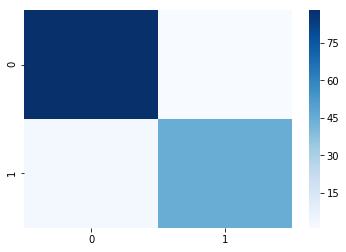

In [24]:
pred_mat = metrics.confusion_matrix(ytest, pred)#, labels=['benign', 'malignant'])
sns.heatmap(pred_mat, cmap='Blues')

In [25]:
log_fit.coef_

array([[ 0.23726406,  0.44106662,  0.16799688, -0.07519684,  0.3644476 ,
         0.0481293 ,  0.24485266,  0.11532974]])

In [21]:
#remove variables that are insignificant to see how a simpler model perofrms
data_sub.columns


Index(['thickness', 'u_size', 'adhesion', 'size', 'bare', 'chromatin',
       'nucleoli', 'mitoses'],
      dtype='object')

In [22]:
Xtrain_simple = Xtrain.drop(['size', 'chromatin'], axis=1)
Xtest_simple = Xtest.drop(['size', 'chromatin'], axis=1)

#### l2 regularizaton suggested dropping both, l1 also dropped size. After comparing both ways, including size didn't help, so chose to drop both

In [23]:
simple_model = linear_model.LogisticRegression(penalty='l1',C=1, fit_intercept = True)
simple_fit = simple_model.fit(Xtrain_simple, ytrain)
print(simple_fit.score(Xtest_simple, ytest))
print(simple_fit.coef_)

0.9708029197080292
[[0.41683876 0.43146195 0.24029115 0.42223572 0.28247862 0.20455441]]


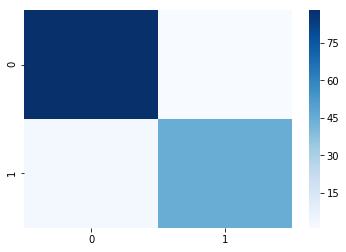

In [24]:
pred_simple = simple_fit.predict(Xtest_simple)
pred_simple_mat = metrics.confusion_matrix(ytest, pred_simple)
sns.heatmap(pred_simple_mat, cmap='Blues')

#### Dropping the two variables with coefficients <0.1 has not reduced model fit, so keeping these out now

In [25]:
print(metrics.classification_report(ytest, pred_simple))
print(simple_fit.coef_)
print(Xtrain_simple.columns)

             precision    recall  f1-score   support

          0       0.97      0.99      0.98        89
          1       0.98      0.94      0.96        48

avg / total       0.97      0.97      0.97       137

[[0.41683876 0.43146195 0.24029115 0.42223572 0.28247862 0.20455441]]
Index(['thickness', 'u_size', 'adhesion', 'bare', 'nucleoli', 'mitoses'], dtype='object')


### Based on the model outputs, thickness, size, and  bare nucleis have largest effect on a cell being malignant

#### Try without an intercept

In [26]:
noint_model = linear_model.LogisticRegression(penalty='l2',C=1, fit_intercept = False)
noint_fit = noint_model.fit(Xtrain_simple, ytrain)
print(noint_fit.score(Xtest_simple, ytest))
print(noint_fit.coef_)

0.708029197080292
[[-0.44727193  0.56460558 -0.06384336  0.35132667  0.12488727 -0.46685748]]


#### Much poorer fit, keep intercept

### Check for significant interactions

In [27]:
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
Xtrain_poly = poly.fit_transform(Xtrain_simple)
Xtest_poly = poly.fit_transform(Xtest_simple)

In [28]:
poly_fit = simple_model.fit(Xtrain_poly, ytrain)
pred_poly = poly_fit.predict(Xtest_poly)
print(metrics.classification_report(ytest, pred_poly))
print(poly_fit.coef_)

             precision    recall  f1-score   support

          0       0.95      0.98      0.96        89
          1       0.96      0.90      0.92        48

avg / total       0.95      0.95      0.95       137

[[-1.20517413e-01  1.49573923e-01  7.70541740e-02  8.43142987e-01
   0.00000000e+00 -3.04232549e-01  8.07438376e-02 -5.46319859e-03
  -1.50097639e-01  5.25357866e-02 -1.67282027e-02  1.04673603e-01
  -6.25491211e-02  1.64192225e-01 -8.40803817e-02 -1.02068993e-03
   5.99947987e-01  6.17373589e-02 -5.37193213e-02  2.87990891e-02
   0.00000000e+00  2.10338306e-02 -2.68481475e-04 -2.88891233e-01
   6.76754836e-02 -3.12756525e-01  1.01269114e-01]]


#### Overall model fit is reduced with all of them, try removing most insignificant and keeping others

In [29]:
#want to keep variables: 4, 9, 14, 17, 24, 26
keep = [4, 9, 14, 17, 24, 26]
print([poly.get_feature_names()[i] for i in keep])
#poly.get_feature_names()[4, 9, 14, 17, 24, 26]

['x4', 'x0 x3', 'x1 x3', 'x2^2', 'x4^2', 'x5^2']


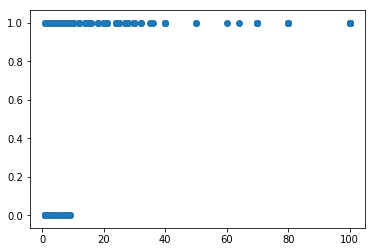

In [30]:
plt.scatter(Xtrain_poly[:,16], ytrain)
plt.show()

In [31]:
#make dataframe of just these columns
keep_idx = [idx-1 for idx in keep]
Xtrain_simple_poly = pd.DataFrame(Xtrain_poly).filter(items=keep_idx)
Xtest_simple_poly = pd.DataFrame(Xtest_poly).filter(items=keep_idx)
Xtrain_simple_poly.shape

(546, 6)

In [32]:
poly_simple_fit = simple_model.fit(Xtrain_simple_poly, ytrain)
pred_simple_poly = poly_simple_fit.predict(Xtest_simple_poly)
print(metrics.classification_report(ytest, pred_simple_poly))
print(poly_simple_fit.coef_)
print(poly_simple_fit.score(Xtest_simple_poly,ytest))

             precision    recall  f1-score   support

          0       0.97      0.99      0.98        89
          1       0.98      0.94      0.96        48

avg / total       0.97      0.97      0.97       137

[[ 0.79741626  0.04657441  0.0335112   0.35448913 -0.278148    0.24582573]]
0.9708029197080292


#### Overall model fit, precision, recall is the same. And this has the same number of variables as no interactions. So, for interpretability, don't use this interactions model. Continue with simple model as best choice (so far).

In [33]:
rf = ensemble.RandomForestClassifier(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(Xtrain, ytrain)
pred_rf = rf.predict(Xtest)
print(metrics.classification_report(ytest, pred_rf))
print(rf.score(Xtest, ytest))

             precision    recall  f1-score   support

          0       0.96      0.98      0.97        89
          1       0.96      0.92      0.94        48

avg / total       0.96      0.96      0.96       137

0.9562043795620438


#### Haven't tried tuning this yet, but has a slight loss of accuracy and far more complicated than logistic regression. Unlikely that tuning will increase its performance enough above logistic to warrant its use

In [34]:
n_estimators = [50, 100, 1000]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(3, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
criteria = ['gini', 'entropy']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criteria}
#print(random_grid)
rf_random = model_selection.RandomizedSearchCV(estimator=rf,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=3,
                               verbose=2,
                               random_state=42,
                               n_jobs=-1)
# Fit the random search model
random_fit = rf_random.fit(Xtrain, ytrain)




Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=67, criterion=entropy, bootstrap=False 
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=67, criterion=entropy, bootstrap=False 
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=67, criterion=entropy, bootstrap=False 
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=24, criterion=entropy, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=67, criterion=entropy, bootstrap=False, total=   0.1s
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=67, criterion=entropy, bootstrap=False, total=   0.2s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=24, criterion=entropy

[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=110, criterion=entropy, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=35, criterion=gini, bootstrap=True, total=   7.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=99, criterion=gini, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=99, criterion=gini, bootstrap=False, total=   0.1s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=99, criterion=gini, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=35, criterion=gini, bootstrap=True, total=   5.7s
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=35, criterion=gini, bootstrap=True, total=   7.4s
[CV] n_estimators=50, min

[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   17.4s


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=3, criterion=entropy, bootstrap=False, total=   0.4s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=110, criterion=gini, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=110, criterion=gini, bootstrap=True, total=   0.3s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=110, criterion=gini, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=110, criterion=gini, bootstrap=True, total=   0.2s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=110, criterion=gini, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=110, criterion=gini, bootstrap=True, total=   0.3s
[CV] n_estimators=1000

[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=3, criterion=gini, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=24, criterion=gini, bootstrap=False, total=   6.0s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=3, criterion=entropy, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=3, criterion=entropy, bootstrap=False, total=   0.2s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=3, criterion=entropy, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=3, criterion=entropy, bootstrap=False, total=   0.2s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=3, criterion=entropy, bootstrap=False 
[CV]  n_estimators=100, min_sample

[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=35, criterion=gini, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=13, criterion=gini, bootstrap=True, total=   2.6s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=35, criterion=entropy, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=35, criterion=entropy, bootstrap=True, total=   0.9s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=35, criterion=entropy, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=35, criterion=entropy, bootstrap=True, total=   0.2s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=35, criterion=entropy, bootstrap=True 
[CV]  n_estimators=50, min_samples_

[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=99, criterion=entropy, bootstrap=False, total=   0.1s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=99, criterion=entropy, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=45, criterion=entropy, bootstrap=True, total=   0.3s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=13, criterion=gini, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=99, criterion=entropy, bootstrap=False, total=   0.2s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=13, criterion=gini, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=99, criterion=entropy, bootstrap=False, total=   0.1s
[CV]  n_estimat

[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=None, criterion=entropy, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=None, criterion=entropy, bootstrap=False, total=   0.2s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=None, criterion=entropy, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=35, criterion=entropy, bootstrap=False, total=   1.7s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=13, criterion=gini, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=None, criterion=entropy, bootstrap=False, total=   0.2s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=13, criterion=gini, bootstrap=True 
[CV]  n_estimator

[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.1min


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=13, criterion=gini, bootstrap=True, total=   0.2s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=56, criterion=entropy, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=13, criterion=gini, bootstrap=True, total=   0.2s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=56, criterion=entropy, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=13, criterion=gini, bootstrap=True, total=   0.3s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=56, criterion=entropy, bootstrap=True 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=56, criterion=entropy, bootstrap=True, total=   0.3s
[CV] n_estimators=50, 

[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=99, criterion=entropy, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=99, criterion=gini, bootstrap=False, total=   2.5s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=None, criterion=entropy, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=99, criterion=entropy, bootstrap=True, total=   1.3s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=None, criterion=entropy, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=99, criterion=gini, bootstrap=False, total=   9.5s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=None, criterion=entropy, bootstrap=True 
[CV]  n_estimators=1000, m

[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=35, criterion=entropy, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=35, criterion=entropy, bootstrap=True, total=   0.1s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=35, criterion=gini, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=35, criterion=entropy, bootstrap=True, total=   0.1s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=35, criterion=gini, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=35, criterion=entropy, bootstrap=True, total=   0.1s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=35, criterion=gini, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=5, min

[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=110, criterion=gini, bootstrap=True, total=   0.1s
[CV] n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=110, criterion=gini, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=110, criterion=gini, bootstrap=True, total=   0.1s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=88, criterion=entropy, bootstrap=False 
[CV]  n_estimators=50, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=110, criterion=gini, bootstrap=True, total=   0.1s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=88, criterion=entropy, bootstrap=False 
[CV]  n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=88, criterion=entropy, bootstrap=False, total=   0.2s
[CV]  n_estimators=10

[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=88, criterion=gini, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, criterion=entropy, bootstrap=False, total=   8.0s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=88, criterion=gini, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, criterion=entropy, bootstrap=False, total=   1.7s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=67, criterion=gini, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=88, criterion=gini, bootstrap=False, total=   1.6s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=67, criterion=gini, bootstrap=True 
[CV]  n_estimators=50, min_sa

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.8min finished


In [35]:
rf_random.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 3,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 100}

In [36]:
# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [False],
    'max_depth': [2, 3, 4],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [90, 100, 110],
    'criterion': ['entropy']
}
# Instantiate the grid search model
grid_search = model_selection.GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=3,
                           n_jobs=-1,
                           verbose=2)

In [37]:
grid_fit = grid_search.fit(Xtrain, ytrain)
grid_search.best_params_

best_grid = grid_search.best_estimator_

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=90 
[CV] bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=90 
[CV] bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=90 
[CV] bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=90, total=   0.1s
[CV]  bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=90, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estim

[CV] bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=90 
[CV]  bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=90, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=110, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=110 
[CV]  bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=90, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=False, criterion=en

[CV]  bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=110, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=110 
[CV]  bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=110, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=90 
[CV]  bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100, total=   0.2s
[CV] bootstrap=Fa

[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    3.1s


[CV]  bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=100, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=110 
[CV]  bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=90, total=   0.2s
[CV]  bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=110, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=5, n_estimators=110 
[CV] bootstrap=Fa

[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=110 
[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=90 
[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=110, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=90 
[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100 
[CV]  bootstrap=False, criterion=

[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=110, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=90 
[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=110, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=90, total=   0.2s
[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=90, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100 
[CV] bootstrap=Fals

[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=90, total=   0.1s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=90, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=110 
[CV]  bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=100, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=3, max_features=auto, min_samples_leaf=3, min_samples_split=6, n_estimators=110 
[CV]  bootstrap=False, criterion=

[CV]  bootstrap=False, criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=110 
[CV]  bootstrap=False, criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100, total=   0.2s
[CV]  bootstrap=False, criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=100, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=110 
[CV] bootstrap=False, criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=90 
[CV]  bootstrap=False, criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=110, total=   0.2s
[CV] bootstrap=Fa

[CV] bootstrap=False, criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  bootstrap=False, criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=90 


[Parallel(n_jobs=-1)]: Done 211 tasks      | elapsed:   17.8s


[CV]  bootstrap=False, criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=110, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  bootstrap=False, criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=90, total=   0.2s
[CV] bootstrap=False, criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=110, total=   0.3s
[CV] bootstrap=False, criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=100 
[CV]  bootstrap=False, criterion=entropy, max_depth=4, max_features=auto, min_samples_leaf=3, min_samples_split=4, n_estimators=90, total=   0.2s
[CV] bootstrap=Fals

[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:   20.2s finished


In [38]:
print(best_grid)

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            n_estimators=90, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)


In [39]:
#train the model on training data
rf_grid = best_grid
rf_best = ensemble.RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            n_estimators=90, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [40]:
rf_best.fit(Xtrain, ytrain)
pred_rf_best = rf_best.predict(Xtest)
print(metrics.classification_report(ytest, pred_rf_best))
print(rf_best.score(Xtest, ytest))

             precision    recall  f1-score   support

          0       0.98      0.97      0.97        89
          1       0.94      0.96      0.95        48

avg / total       0.96      0.96      0.96       137

0.9635036496350365


#### As expected, tuning RF didn't help enough

### Overall, the logistic regression with 6 features was the best model. This includes'thickness', 'u_size', 'adhesion', 'bare','nucleoli', and 'mitoses'.